# Ensemble sorting of a 3Brain Biocam recording from a mouse retina

This notebook reproduces supplemental figure S3 from the paper [**SpikeInterface, a unified framework for spike sorting**](https://www.biorxiv.org/content/10.1101/796599v2).

The recording was made by [Gerrit Hilgen](https://www.northumbria.ac.uk/about-us/our-staff/h/gerrit-hilgen/) in the lab of [Evelyne Sernagor](https://www.ncl.ac.uk/medical-sciences/people/profile/evelynesernagor.html), University of Newcastle.

The data set for this notebook is available on the Dandi Archive: [https://gui.dandiarchive.org/#/dandiset/000034](https://gui.dandiarchive.org/#/dandiset/000034)

The entire data archive can be downloaded with the command `dandi download https://gui.dandiarchive.org/#/dandiset/000034/draft` (about 75GB).

File required to run the code:
- the raw data: [sub-P29-16-05-14-retina02-left_ecephys.nwb](https://girder.dandiarchive.org/api/v1/item/5f2d8245ee8baa608594a40c/download)

The file should be in the same directory where the notebook is located (otherwise adjust paths below).

Author: [Matthias Hennig](http://homepages.inf.ed.ac.uk/mhennig/), University of Edinburgh, 24 Aug 2020

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface
- dandi

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

In [1]:
import os

# Matlab sorter paths:
# change these to match your environment
os.environ["IRONCLUST_PATH"] = "./ironclust"
os.environ["KILOSORT2_PATH"] = "./Kilosort2"
os.environ["HDSORT_PATH"] = "./HDsort"

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib_venn import venn3

import spikeinterface as si
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy, MultiSortingComparison

%matplotlib inline

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# print version information
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.9
  * spikeextractor: 0.8.4
  * spiketoolkit: 0.6.3
  * spikesorters: 0.3.3
  * spikecomparison: 0.2.6
  * spikewidgets: 0.4.3

hdsort: version = '1.0.2'

herdingspikes: 0.3.7
ironclust: 5.9.8
kilosort2: git-48bf2b81d8ad
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.7
tridesclous: 1.6.0


In [2]:
# the recording file, downloaded from Dandi in NWB:N format 
data_file =  './sub-P29-16-05-14-retina02-left_ecephys.nwb'

# paths for spike sorter outputs
p = Path('./')

# select spike sorters to be used, note Kilosort2 requires a NVIDIA GPU to run
sorter_list = ['herdingspikes', 'kilosort2', 'ironclust', 'hdsort']
sorter_params = {'spyking_circus': {'adjacency_radius': 50}, 'herdingspikes': {'filter': True, }}
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',  'HDSort']
sorter_names_short = ['HS', 'KS', 'IC', 'HDS']

# create a recording extractor, this gives access to the raw data in the NWB:N file
recording = se.NwbRecordingExtractor(data_file)

# this recording has some bad artefcats, and these are easily blanked out using spiketoolkit
# note that no spike sorter can handle these artefacts well, so this step is essential
recording = st.preprocessing.blank_saturation(recording)
# (aside: the warning below can be ignored, artefacts are quite sparse but definetely there, the check
# if very conservative)

# NWB:N files store the data in (channels:time) order, but for spike sorting the transposed format is much
# more efficient. Therefore here we create a CacheRecordingExtractor that re-writes the data
# as a binary file in the desired order. This will take some time, but speeds up subsequent steps:
recording = se.CacheRecordingExtractor(recording)

# print some info
print("Sampling rate: {}Hz".format(recording.get_sampling_frequency()))
print("Duration: {}s".format(recording.get_num_frames()/recording.get_sampling_frequency()))
print("Number of channels: {}".format(recording.get_num_channels()))

Warning, narrow signal range suggests artefact-free data.
Sampling rate: 23199.090358491783Hz
Duration: 135.7303218075276s
Number of channels: 1024


# Run spike sorters and perform comparison between all outputs

In [3]:
# now create the study environment and run all spike sorters
# note that this function will not re-run a spike sorter if the sorting is already present in
# the working folder

study_folder = p / 'study/'
working_folder = p / 'working/'
if not study_folder.is_dir():
    print('Setting up study folder:', study_folder)
    os.mkdir(study_folder)
rec_dict = {'rec': recording}

result_dict = ss.run_sorters(sorter_list=sorter_list, recording_dict_or_list=rec_dict, with_output=True,
                             sorter_params=sorter_params, working_folder=working_folder, engine='loop', 
                             mode='keep', verbose=True)

# when done, load all sortings into a handly list
sortings = []
for s in sorter_list:
    sortings.append(result_dict['rec',s])

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/spikeextractors/extractors/matsortingextractor/matsortingextractor.py:65: ResourceWarning: unclosed file <_io.BufferedReader name='/disk/scratch/mhennig/spikeinterface/retina_short/working/rec/hdsort/hdsort_output/hdsort_output_results.mat'>
  raise ImportError("Version 7.2 .mat file given, but you don't have h5py installed.")


In [4]:
# run a multi-sorting comparison, an all-to-all comparison
# results are saved and just loaded from a file if this exists

if not os.path.isfile(study_folder / 'multicomparison.gpickle'):
    mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                                       verbose=True)
    print('saving multicomparison')
    mcmp.dump(study_folder)
else:
    print('loading multicomparison')
    mcmp = sc.MultiSortingComparison.load_multicomparison(study_folder)

loading multicomparison
Multicomaprison step 3: clean graph
Removed edge ('KS_244', 'HS_18', {'weight': 0.6169491525423729})
Removed edge ('IC_181', 'HDS_137003', {'weight': 0.9284436493738819})
Removed edge ('HDS_450004', 'KS_1160', {'weight': 0.5208791208791209})
Removed 3 duplicate nodes
Multicomaprison step 4: extract agreement from graph


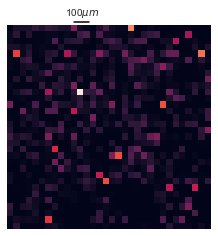

In [5]:
# plot an activity map
# as the channel count is high, here we use the spikes detected by HS2
# they are easily retrieved from the sorting results

sx = result_dict['rec','herdingspikes']
n,v = np.histogram(sx._rf['ch'], bins=np.arange(1025))

ax = plt.subplot(111)
ax.imshow(n.reshape((32,32)))
ax.set_xticks(())
ax.set_yticks(())
ax.plot((10,10+100/42),(-1,-1),'k-')
ax.annotate('100$\\mu m$',(10+100/42/2,-2), ha='center');
ax.axis('off')
ax.set_aspect('equal')

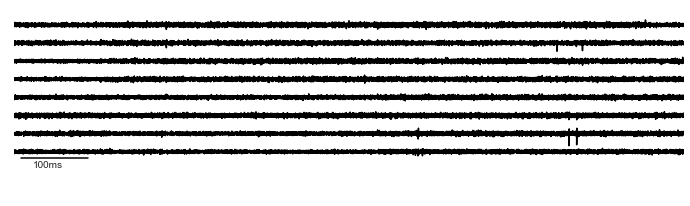

In [6]:
# next we plot some raw data traces
# for better visualisation, we bandpass filter the traces before showing them
# to this end, we use a lazy bandpass filter from spiketoolkit
recording_bandpass = st.preprocessing.bandpass_filter(recording)
plt.figure(figsize=(12,3))
ax = plt.subplot(111)
w = sw.plot_timeseries(recording_bandpass, channel_ids=range(300,308), color='k', ax=ax, trange=(2,3))
ax.plot((2.01,2.11),(-50,-50),'k-');
ax.annotate('100ms',(2.051,-120), ha='center');
ax.axis('off');


Text(0, 0.5, 'Units detected')

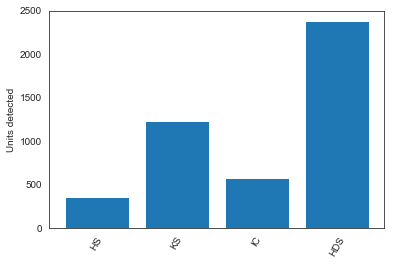

In [7]:
# number of units found by each sorter
ax = plt.subplot(111)
ax.bar(range(len(sortings)), [len(s.get_unit_ids()) for s in sortings])
ax.set_xticks(range(len(sorter_names)))
ax.set_xticklabels(sorter_names_short, rotation=60, ha='center')
ax.set_ylabel('Units detected') 

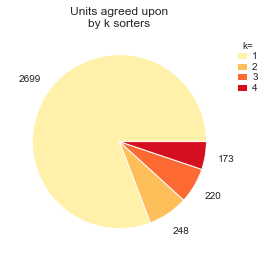

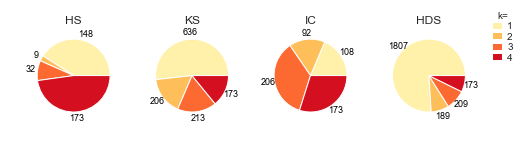

In [8]:
# spikewidgets provides handy widgets to plot summary statistics of the comparison

# show the number of units agreed upon by k sorters, in aggregate
plt.figure()
ax = plt.subplot(111)
w = sw.plot_multicomp_agreement(mcmp, plot_type='pie', ax=ax)

# show the number of units agreed upon by k sorters, per sorter
plt.figure()
ax = plt.subplot(111)
w = sw.plot_multicomp_agreement_by_sorter(mcmp, show_legend=True, ax=ax)